In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from velocity.chemistry import Species, Reaction, Network, Experiment, ExperimentBuilder
from math import sqrt

In [98]:
dose_times_df = pd.read_excel("catalyst_death_data.xlsx", sheet_name="dose_times")
dose_times_df.set_index("experiment", inplace=True)
dose_times_df.head()

,dose_time
experiment,
1,0
2,7200
3,18000
4,28800
5,46800


In [99]:
observations_df = pd.read_excel("catalyst_death_data.xlsx", sheet_name="observations")
observations_df.head()

,experiment,time_since_dose,gal,tal,glc,all
0,1,900,0.170909,0.010909,0.080366,0.010543
1,1,1800,0.158182,0.020000,0.072623,0.018286
2,2,900,0.096364,0.072727,0.082349,0.008560
3,2,1800,0.090909,0.074545,0.076246,0.014663
4,3,900,0.041818,0.120000,0.083176,0.007733


In [100]:
times, galactose_concentrations, talose_concentrations, glucose_concentrations, allose_concentrations = [], [], [], [], []

for _,row in observations_df.iterrows():
    experiment, time_since_dose, galactose, talose, glucose, allose = row
    
    t = dose_times_df.loc[experiment][0] + time_since_dose
    times.append(t)
    
    galactose_concentrations.append(galactose)
    talose_concentrations.append(talose)
    glucose_concentrations.append(glucose)
    allose_concentrations.append(allose)
    
galactose_concentrations = np.array(galactose_concentrations)
talose_concentrations = np.array(talose_concentrations)

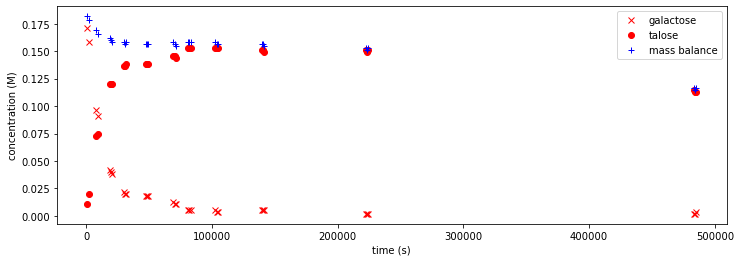

In [101]:
plt.figure(figsize=(12,4))
plt.plot(times, galactose_concentrations, "rx", label="galactose")
plt.plot(times, talose_concentrations, "ro", label="talose")
plt.plot(times, galactose_concentrations + talose_concentrations, "b+", label="mass balance")
plt.legend(loc="upper right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.show()

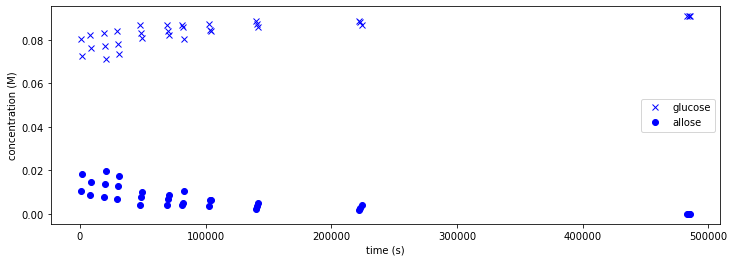

In [102]:
plt.figure(figsize=(12,4))
# plt.plot(times, galactose_concentrations, "rx", label="galactose")
# plt.plot(times, talose_concentrations, "ro", label="talose")
plt.plot(times, glucose_concentrations, "bx", label="glucose")
plt.plot(times, allose_concentrations, "bo", label="allose")
plt.legend(loc="center right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.show()

In [103]:
glucose = Species("Glc", "glucose")
allose = Species("All", "allose")

galactose = Species("Gal", "galactose")
talose = Species("Tal", "talose")

#sugar_dead = Species("sug_d", "sugar (dead)")
sugar_other = Species("sug_o", "sugar (others)")

catalyst_active = Species("cat", "catalyst (active)")
catalyst_dead = Species("cat_d", "catalyst (dead)")

deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
#destruction_reaction1 = Reaction({galactose:1, catalyst_active:1}, {sugar_dead:1, catalyst_active:1}, reversible=False)
#destruction_reaction2 = Reaction({talose:1, catalyst_active:1}, {sugar_dead:1, catalyst_active:1}, reversible=False)

In [104]:
def make_network(allose_rate_constant,
                 allose_selectivity,
                 talose_rate_constant,
                 talose_selectivity,
                 other_rate_constant,
                 other_selectivity,
                 deactivation_rate_constant,
                 #destruction_rate_constant,
                ):
    reactions_dict = {}
    reactions_dict[deactivation_reaction] = deactivation_rate_constant
    #reactions_dict[destruction_reaction1] = destruction_rate_constant
    #reactions_dict[destruction_reaction2] = destruction_rate_constant
    
    def connect(base_rate_constant, sugar1, sugar2, overall_selectivity):
        jk1 = base_rate_constant*sqrt(overall_selectivity)
        jk2 = base_rate_constant/sqrt(overall_selectivity)
        reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
        reactions_dict[reaction] = (jk1,jk2)
    
    connect(allose_rate_constant, glucose, allose, allose_selectivity)
    connect(talose_rate_constant, galactose, talose, talose_selectivity)
    connect(other_rate_constant, galactose, sugar_other, other_selectivity)
    network = Network(reactions_dict, fixed_concentrations=None)
    return network

In [105]:
network = make_network(allose_rate_constant=0.011,
                       allose_selectivity=10.0,
                       talose_rate_constant=0.012,
                       talose_selectivity=10.0,
                       other_rate_constant=0.012*10,
                       other_selectivity=1.0,
                       deactivation_rate_constant=0.000014,
                       #destruction_rate_constant=0.00,
                      )

In [106]:
initial_concentrations_dict = {
            galactose : 0.18,
            catalyst_active : 0.18*0.02
        }
t_span=(0,500000)
t_eval={i for i in np.arange(0,500000,20000)}
t_eval.update(times)
t_eval = np.array(sorted(t_eval))
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

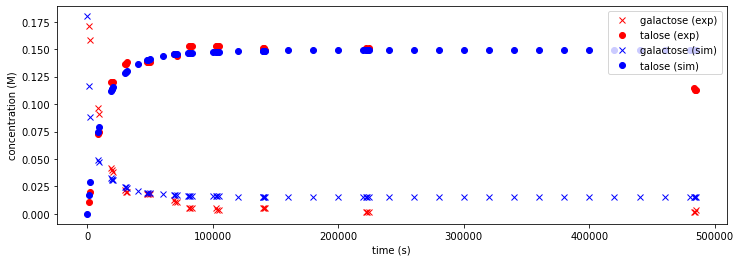

In [107]:
plt.figure(figsize=(12,4))
plt.plot(times, galactose_concentrations, "rx", label="galactose (exp)")
plt.plot(times, talose_concentrations, "ro", label="talose (exp)")
plt.plot(concentrations_df.index, concentrations_df["Gal"], "bx", label="galactose (sim)")
plt.plot(concentrations_df.index, concentrations_df["Tal"], "bo", label="talose (sim)")
plt.legend(loc="upper right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.show()

In [88]:
def create_experiments():
    experiments = []
    builder = None
    eval_times = np.arange(0,500000,10000)
    initial_concentrations_dict = { galactose:0.18, catalyst_active:0.18*0.02 }
    
    for i,row in observations_df.iterrows():
        experiment, time_since_dose, galactose_c, talose_c, glucose_c, allose_c = row
        
        dose_time = float(dose_times_df.loc[experiment][0])
        observation_time = float(dose_time + time_since_dose)
        
        if builder is None:
            builder = ExperimentBuilder(network)
            if i > 0:
                builder.schedule_start(initial_concentrations_dict, volume=0.5)
                builder.schedule_addition({glucose:1.0}, volume=0.05, time=dose_time)
            else:
                builder.schedule_start({galactose:0.2*50/55, glucose:0.1*50/55, catalyst_active:0.2*(50/55)*0.02}, volume=0.55)
            builder.observation_map = {}
        
        builder.add_eval_times(observation_time)
        builder.observation_map[observation_time] = [galactose_c, talose_c, glucose_c, allose_c]
        
        last_dose = (i == len(observations_df)-1) or observations_df.loc[i+1]["experiment"] != experiment
        if last_dose:
            builder.schedule_end(time=500000)
            builder.add_eval_times(eval_times)
            experiment = builder.build()
            experiment.observation_map = builder.observation_map
            experiments.append(experiment)
            builder = None
    
    return experiments

In [89]:
def get_rates(experiment):
    x, y = [], []
    for t, concentrations in experiment.observation_map.items():
        galactose_c, talose_c, glucose_c, allose_c = concentrations
        x.append(t)
        y.append(allose_c)
    slope, intercept = np.polyfit(x,y,deg=1)
    experimental_rate = slope
    
    y = []
    for t in x:
        allose_c = experiment.df.loc[t]["All"]
        y.append(allose_c)
    slope, intercept = np.polyfit(x,y,deg=1)
    predicted_rate = slope
    
    return experimental_rate, predicted_rate

In [90]:
experiments = create_experiments()

loss = 0.0
for e in tqdm(experiments):
    e.simulate()
    experimental_rate, predicted_rate = get_rates(e)
    loss += np.square(experimental_rate-predicted_rate)
loss = np.sqrt(loss/len(experiments))
print(f"Loss: {loss:.3e}")

  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 7.215e-07


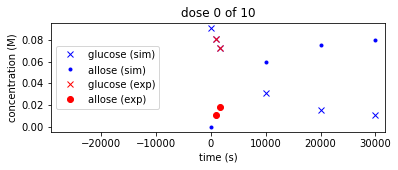

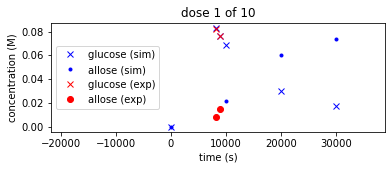

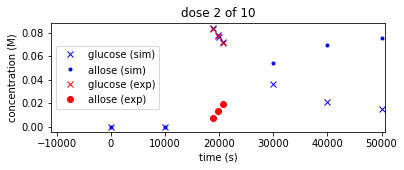

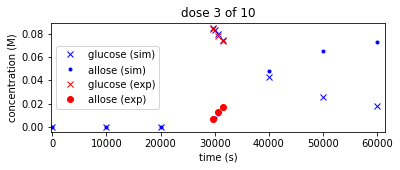

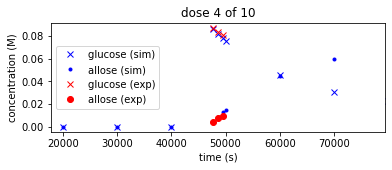

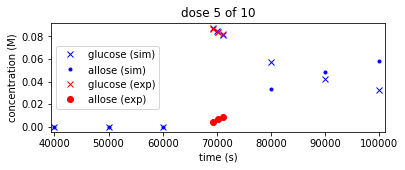

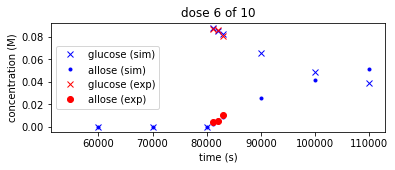

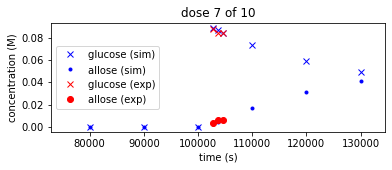

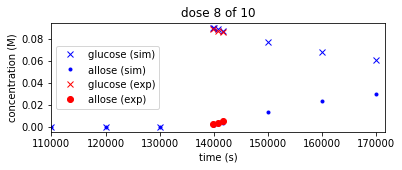

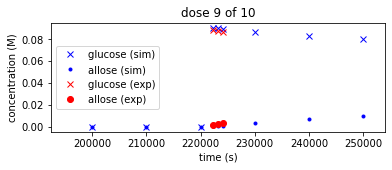

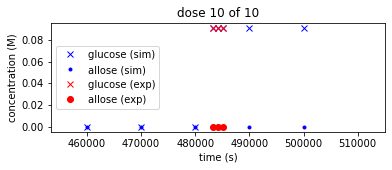

In [110]:
for i in range(0,11,1):
    experiment = experiments[i]
    df = experiment.df
    observation_map = experiment.observation_map
    rows = []
    for t,row in observation_map.items():
        rows.append([t,*row])
        obs_df = DataFrame(rows, columns=["time", "Gal", "Tal", "Glc", "All"])

    plt.figure(figsize=(6,2))
    plt.title(f"dose {i} of 10")
    plt.plot(df.index, df["Glc"], "bx", label="glucose (sim)")
    plt.plot(df.index, df["All"], "b.", label="allose (sim)")
    plt.plot(obs_df.time, obs_df["Glc"], "rx", label="glucose (exp)")
    plt.plot(obs_df.time, obs_df["All"], "ro", label="allose (exp)")
    plt.legend(loc="center left")
    plt.ylabel("concentration (M)")
    plt.xlabel("time (s)")
    plt.xlim(obs_df.time.min()-30000,obs_df.time.max()+30000)
    plt.show()

7


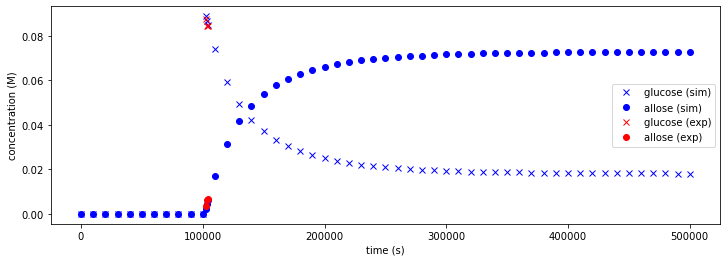

In [92]:
for i in [7]:
    print(i)
    experiment = experiments[i]
    df = experiment.df
    observation_map = experiment.observation_map
    rows = []
    for t,row in observation_map.items():
        rows.append([t,*row])
        obs_df = DataFrame(rows, columns=["time", "Gal", "Tal", "Glc", "All"])

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["Glc"], "bx", label="glucose (sim)")
    plt.plot(df.index, df["All"], "bo", label="allose (sim)")
    plt.plot(obs_df.time, obs_df["Glc"], "rx", label="glucose (exp)")
    plt.plot(obs_df.time, obs_df["All"], "ro", label="allose (exp)")
    plt.legend(loc="center right")
    plt.ylabel("concentration (M)")
    plt.xlabel("time (s)")
    plt.show()

In [93]:
glucose_df = pd.read_excel("catalyst_death_data.xlsx", sheet_name="glucose_only")
glucose_df = glucose_df.query("time < 11000")
glucose_df.head()

,time,glc,all,man,tal
0,240,0.188,0.008,0.000,0.0
1,600,0.184,0.018,0.000,0.0
2,1500,0.166,0.034,0.002,0.0
3,2400,0.146,0.054,0.002,0.0
4,3600,0.116,0.074,0.002,0.0


In [94]:
network = make_network(allose_rate_constant=0.011,
                       allose_selectivity=10.0,
                       talose_rate_constant=0.012,
                       talose_selectivity=10.0,
                       other_rate_constant=0.012*10,
                       other_selectivity=1.0,
                       deactivation_rate_constant=0.00001,
                       #destruction_rate_constant=0.00,
                      )

In [95]:
initial_concentrations_dict = {
            glucose : 0.2,
            catalyst_active : 0.2*0.02
        }
t_span=(0,11000)
t_eval=glucose_df.time.to_numpy()
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

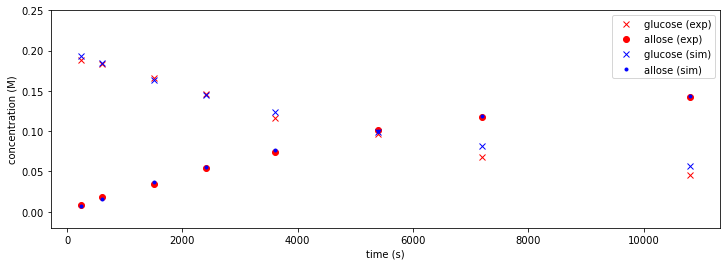

In [96]:
plt.figure(figsize=(12,4))
plt.plot(glucose_df.time, glucose_df["glc"], "rx", label="glucose (exp)")
plt.plot(glucose_df.time, glucose_df["all"], "ro", label="allose (exp)")
plt.plot(concentrations_df.index, concentrations_df["Glc"], "bx", label="glucose (sim)")
plt.plot(concentrations_df.index, concentrations_df["All"], "b.", label="allose (sim)")
plt.legend(loc="upper right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.ylim(-0.02,0.25)
plt.show()

In [ ]:
def create_experiments(allose_rate_constant,
                       allose_selectivity,
                       talose_rate_constant,
                       talose_selectivity,
                       other_rate_constant,
                       other_selectivity,
                       deactivation_rate_constant):
 
    reactions_dict = {}
    def connect(base_rate_constant, sugar1, sugar2, overall_selectivity):
        jk1 = base_rate_constant*sqrt(overall_selectivity)
        jk2 = base_rate_constant/sqrt(overall_selectivity)
        reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
        reactions_dict[reaction] = (jk1,jk2)
    
    glucose = Species("Glc", "glucose")
    allose = Species("All", "allose")

    galactose = Species("Gal", "galactose")
    talose = Species("Tal", "talose")

    catalyst_active = Species("cat", "catalyst (active)")
    catalyst_dead = Species("dead", "catalyst (dead)")

    reaction1 = Reaction({glucose:1, catalyst_active:1}, {allose:1, catalyst_active:1}, reversible=True)
    reaction2 = Reaction({glucose:1, catalyst_active:1}, {allose:1, catalyst_active:1}, reversible=True)
    deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    
    connect(allose_rate_constant, glucose, allose, allose_selectivity)
    connect(talose_rate_constant, galactose, talose, talose_selectivity)
    reactions_dict[deactivation_reaction] = deactivation_rate_constant
    network = Network(reactions_dict, fixed_concentrations=None)

    experiments = []
    builder = None
    eval_times = np.arange(0,500000,10000)
    initial_concentrations_dict = { galactose:0.2, catalyst_active:0.2*0.02 }
    
    for i,row in observations_df.iterrows():
        experiment, time_since_dose, galactose_c, talose_c, glucose_c, allose_c = row
        
        dose_time = float(dose_times_df.loc[experiment][0])
        observation_time = float(dose_time + time_since_dose)

        galactose_c = convert_to_concentration(galactose_c)
        talose_c = convert_to_concentration(talose_c)
        glucose_c = convert_to_concentration(glucose_c)
        allose_c = convert_to_concentration(allose_c)
        
        if builder is None:
            builder = ExperimentBuilder(network)
            if i > 0:
                builder.schedule_start(initial_concentrations_dict, volume=0.5)
                builder.schedule_addition({glucose:1.0}, volume=0.05, time=dose_time)
            else:
                builder.schedule_start({galactose:0.2*50/55, glucose:0.1*50/55, catalyst_active:0.2*(50/55)*0.02}, volume=0.55)
            builder.observation_map = {}
        
        builder.add_eval_times(observation_time)
        builder.observation_map[observation_time] = [galactose_c, talose_c, glucose_c, allose_c]
        
        last_dose = (i == len(observations_df)-1) or observations_df.loc[i+1]["experiment"] != experiment
        if last_dose:
            builder.schedule_end(time=500000)
            builder.add_eval_times(eval_times)
            experiment = builder.build()
            experiment.observation_map = builder.observation_map
            experiments.append(experiment)
            builder = None
    
    return experiments

In [ ]:
def get_rates(experiment):
    x, y = [], []
    for t, concentrations in experiment.observation_map.items():
        galactose_c, talose_c, glucose_c, allose_c = concentrations
        x.append(t)
        y.append(allose_c)
    slope, intercept = np.polyfit(x,y,deg=1)
    experimental_rate = slope
    
    y = []
    for t in x:
        allose_c = experiment.df.loc[t]["All"]
        y.append(allose_c)
    slope, intercept = np.polyfit(x,y,deg=1)
    predicted_rate = slope
    
    return experimental_rate, predicted_rate

In [ ]:
experiments = create_experiments(allose_rate_constant=0.012,
                       allose_selectivity=10.0,
                       talose_rate_constant=0.005,
                       talose_selectivity=10.0,
                       deactivation_rate_constant=0.0000207)

loss = 0.0
for e in tqdm(experiments):
    e.simulate()
    experimental_rate, predicted_rate = get_rates(e)
    loss += np.square(experimental_rate-predicted_rate)
loss = np.sqrt(loss/len(experiments))
print(f"Loss: {loss:.3e}")

In [ ]:
for i in range(0,11,2):
    experiment = experiments[i]
    df = experiment.df
    observation_map = experiment.observation_map
    rows = []
    for t,row in observation_map.items():
        rows.append([t,*row])
        obs_df = DataFrame(rows, columns=["time", "Gal", "Tal", "Glc", "All"])

#     plt.figure(figsize=(12,4))
#     plt.plot(df.index, df["Gal"], "bx", label="galactose (sim)")
#     plt.plot(df.index, df["Tal"], "bo", label="talose (sim)")
#     plt.plot(obs_df.time, obs_df["Gal"], "rx", label="galactose (exp)")
#     plt.plot(obs_df.time, obs_df["Tal"], "ro", label="talose (exp)")

#     plt.legend(loc="center right")
#     plt.ylabel("concentration (M)")
#     plt.xlabel("time (s)")
#     plt.xlim(obs_df.time.min()-50000,obs_df.time.max()+50000)
#     plt.show()

    plt.figure(figsize=(6,2))
    plt.title(f"dose {i} of 12")
    plt.plot(df.index, df["Glc"], "bx", label="glucose (sim)")
    plt.plot(df.index, df["All"], "b.", label="allose (sim)")
    plt.plot(obs_df.time, obs_df["Glc"], "rx", label="glucose (exp)")
    plt.plot(obs_df.time, obs_df["All"], "ro", label="allose (exp)")
    plt.legend(loc="center left")
    plt.ylabel("concentration (M)")
    plt.xlabel("time (s)")
    plt.xlim(obs_df.time.min()-30000,obs_df.time.max()+30000)
    plt.show()

In [ ]:
for i in [7]:
    print(i)
    experiment = experiments[i]
    df = experiment.df
    observation_map = experiment.observation_map
    rows = []
    for t,row in observation_map.items():
        rows.append([t,*row])
        obs_df = DataFrame(rows, columns=["time", "Gal", "Tal", "Glc", "All"])

#     plt.figure(figsize=(12,4))
#     plt.plot(df.index, df["Gal"], "bx", label="galactose (sim)")
#     plt.plot(df.index, df["Tal"], "bo", label="talose (sim)")
#     plt.plot(obs_df.time, obs_df["Gal"], "rx", label="galactose (exp)")
#     plt.plot(obs_df.time, obs_df["Tal"], "ro", label="talose (exp)")

#     plt.legend(loc="center right")
#     plt.ylabel("concentration (M)")
#     plt.xlabel("time (s)")
#     plt.xlim(obs_df.time.min()-50000,obs_df.time.max()+50000)
#     plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["Glc"], "bx", label="glucose (sim)")
    plt.plot(df.index, df["All"], "bo", label="allose (sim)")
    plt.plot(obs_df.time, obs_df["Glc"], "rx", label="glucose (exp)")
    plt.plot(obs_df.time, obs_df["All"], "ro", label="allose (exp)")
    plt.legend(loc="center right")
    plt.ylabel("concentration (M)")
    plt.xlabel("time (s)")
    plt.show()

In [ ]:
glucose_df = pd.read_excel("catalyst_death_data.xlsx", sheet_name="glucose_only")
glucose_df = glucose_df.query("time < 11000")
glucose_df.head()

In [ ]:
network = make_network(allose_rate_constant=0.012,
                       allose_selectivity=10.0,
                       talose_rate_constant=0.005,
                       talose_selectivity=10.0,
                       deactivation_rate_constant=0.0000207)

In [ ]:
initial_concentrations_dict = {
            glucose : 0.2,
            catalyst_active : 0.2*0.02
        }
t_span=(0,11000)
t_eval=glucose_df.time.to_numpy()
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(glucose_df.time, glucose_df["glc"], "rx", label="glucose (exp)")
plt.plot(glucose_df.time, glucose_df["all"], "ro", label="allose (exp)")
plt.plot(concentrations_df.index, concentrations_df["Glc"], "bx", label="glucose (sim)")
plt.plot(concentrations_df.index, concentrations_df["All"], "b.", label="allose (sim)")
plt.legend(loc="upper right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.ylim(-0.02,0.25)
plt.show()

In [ ]:
initial_concentrations_dict = {
            galactose : 0.2,
            catalyst_active : 0.2*0.02
        }
t_span=(0,500000)
t_eval=times
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(times, galactose_concentrations, "rx", label="galactose (exp)")
plt.plot(times, talose_concentrations, "ro", label="talose (exp)")
plt.plot(concentrations_df.index, concentrations_df["Gal"], "bx", label="galactose (sim)")
plt.plot(concentrations_df.index, concentrations_df["Tal"], "b.", label="talose (sim)")
plt.legend(loc="center right")
plt.ylabel("concentration (M)")
plt.xlabel("time (s)")
plt.show()